In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BackTest_Toolkit import FactorPurify, IndustryNeutralize, simple_factor_test, plot_factor_performance  


In [2]:
df_close = pd.read_excel('中证500.xlsx', sheet_name="close", header=1)
df_close.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_close['Date'] = pd.to_datetime(df_close['Date'], format='%Y-%m-%d')  
df_close.set_index('Date', inplace=True)
df_close.apply(pd.to_numeric, errors='coerce')
print(df_close.head())

df_volume = pd.read_excel('中证500.xlsx', sheet_name="volume", header=1)
df_volume.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)  
df_volume['Date'] = pd.to_datetime(df_volume['Date'], format='%Y-%m-%d')
df_volume.set_index('Date', inplace=True)
df_volume.apply(pd.to_numeric, errors='coerce')
print(df_volume.head())

            000009.SZ  000021.SZ  000027.SZ  000032.SZ  000034.SZ  000039.SZ  \
Date                                                                           
2014-01-02   4.684113   4.879978   2.350680   7.053180   3.849812   6.856300   
2014-01-03   4.559535   4.843560   2.294813   6.973573   3.868101   6.962599   
2014-01-06   4.519670   4.879978   2.243244   6.742713   3.740079   6.732284   
2014-01-07   4.509704   5.107589   2.234650   6.559617   3.767512   6.936024   
2014-01-08   4.429975   5.198633   2.260434   6.702909   3.630345   6.905020   

            000050.SZ  000060.SZ  000062.SZ  000066.SZ  ...  688608.SH  \
Date                                                    ...              
2014-01-02  11.041349   3.534769   6.824298   3.779169  ...        0.0   
2014-01-03  11.050900   3.534769   7.088317   3.798550  ...        0.0   
2014-01-06  10.621090   3.534769   6.847257   3.721028  ...        0.0   
2014-01-07  11.270581   3.534769   6.824298   3.827620  ...        0.

In [3]:
df_industry = pd.read_excel('行业代码500.xlsx', sheet_name="申万", header=0)
print(df_industry.head())

df_total_cap = pd.read_excel('中证500市值.xlsx', sheet_name="total_cap", header=1)
df_total_cap.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_total_cap['Date'] = pd.to_datetime(df_total_cap['Date'], format='%Y-%m-%d')
df_total_cap.set_index('Date', inplace=True)
df_total_cap.apply(pd.to_numeric, errors='coerce')
df_total_cap = df_total_cap.map(lambda x: np.log(x) if x > 0 else np.nan)
df_total_cap_monthly = df_total_cap.resample('ME').last()
print(df_total_cap.head())
print(df_total_cap_monthly.head())


        Code    Industry
0  000009.SZ  801730.SWI
1  000021.SZ  801080.SWI
2  000027.SZ  801160.SWI
3  000032.SZ  801720.SWI
4  000034.SZ  801750.SWI
            000009.SZ  000021.SZ  000027.SZ  000032.SZ  000034.SZ  000039.SZ  \
Date                                                                           
2014-01-02  23.190603  22.788349  23.394457  21.447513  21.133432  24.442041   
2014-01-03  23.163648  22.780858  23.370404  21.436162  21.138172  24.457426   
2014-01-06  23.154866  22.788349  23.347676  21.402497  21.104515  24.423788   
2014-01-07  23.152659  22.833935  23.343837  21.374967  21.111823  24.453602   
2014-01-08  23.134821  22.851604  23.355309  21.396576  21.074736  24.449122   

            000050.SZ  000060.SZ  000062.SZ  000066.SZ  ...  688608.SH  \
Date                                                    ...              
2014-01-02  22.616104  23.284768  22.793923  22.364593  ...        NaN   
2014-01-03  22.616969  23.284768  22.831881  22.369708  ...        

In [4]:
market_mean_close = df_close.mean(axis=1)

## 因子1：每月最大异常日收益
abnret_abs = df_close.sub(market_mean_close, axis=0).abs()
monthly_max_abnret = abnret_abs.resample('ME').max()
# 极值处理：用MAD法替换异常值
M_abnret_max = monthly_max_abnret.apply(
    lambda x: x.clip(
        lower=x.median() - 3 * (1.4826 * (x - x.median()).abs().median()),
        upper=x.median() + 3 * (1.4826 * (x - x.median()).abs().median())
    )
)
# 市值中性化处理
M_abnret_max = FactorPurify(M_abnret_max, [df_total_cap_monthly])
# 行业中性化处理
M_abnret_max = IndustryNeutralize(M_abnret_max, df_industry)

print(M_abnret_max.head())


d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:151: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  factor_res = pd.concat([factor_res, res.resid.rename(idx)], axis=1)


           000009.SZ 000021.SZ 000027.SZ 000032.SZ 000034.SZ 000039.SZ  \
2014-01-31 -1.472355  0.007237 -0.601234 -0.728709 -0.186082  0.397313   
2014-02-28 -0.897523  0.134286 -0.501736 -0.986491 -0.297888  -0.15446   
2014-03-31 -0.431294 -0.203187 -0.487207 -1.085079 -0.275994 -0.107658   
2014-04-30  -0.32421 -0.362251 -0.451132 -0.842967 -0.099705   0.21792   
2014-05-31 -0.548336 -0.453776 -0.502177 -0.619388 -0.257865 -0.629497   

           000050.SZ 000060.SZ 000062.SZ 000066.SZ  ... 688249.SH 688361.SH  \
2014-01-31  7.214098 -2.197425 -2.021763 -1.400161  ...       NaN       NaN   
2014-02-28  7.675979 -2.296015 -1.962013 -1.491583  ...       NaN       NaN   
2014-03-31   6.89491 -2.089928 -1.893437 -1.395437  ...       NaN       NaN   
2014-04-30  7.733617 -1.902339 -1.794568 -0.948094  ...       NaN       NaN   
2014-05-31  7.523123 -1.744096 -1.658757 -0.944188  ...       NaN       NaN   

           688469.SH 688582.SH 688563.SH 301498.SZ 688702.SH 301536.SZ  \
2014-0

In [5]:
## 因子2：每月平均异常日收益
abnret_sqr = df_close.sub(market_mean_close, axis=0).pow(2)
monthly_avg_abnret = abnret_sqr.resample('M').mean()
# 极值处理：用MAD法替换异常值
M_abnret_avg = monthly_avg_abnret.apply(
    lambda x: x.clip(
        lower=x.median() - 3 * (1.4826 * (x - x.median()).abs().median()),
        upper=x.median() + 3 * (1.4826 * (x - x.median()).abs().median())
    )
)
# 市值中性化处理
M_abnret_avg = FactorPurify(M_abnret_avg, [df_total_cap_monthly])
# 行业中性化处理
M_abnret_avg = IndustryNeutralize(M_abnret_avg, df_industry)
print(M_abnret_avg.head())

C:\Users\15799\AppData\Local\Temp\ipykernel_22596\3080999111.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_abnret = abnret_sqr.resample('M').mean()
d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:151: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  factor_res = pd.concat([factor_res, res.resid.rename(idx)], axis=1)


            000009.SZ 000021.SZ  000027.SZ 000032.SZ 000034.SZ  000039.SZ  \
2014-01-31 -12.803485 -9.215253 -11.882255  2.371617  4.960513 -13.850991   
2014-02-28 -13.878604 -8.372953 -12.335777  0.214739  3.561821 -16.691352   
2014-03-31 -11.330677 -7.957546 -11.849374 -0.231547  1.240327 -15.493282   
2014-04-30 -10.314634 -7.671816 -11.180734  0.379034  2.129415 -13.701967   
2014-05-31  -9.933787 -7.315225 -10.628588   1.23854  3.057289 -15.011554   

            000050.SZ  000060.SZ  000062.SZ 000066.SZ  ... 688249.SH  \
2014-01-31  54.486325 -12.875345 -11.051772 -6.804441  ...       NaN   
2014-02-28  69.030913 -14.182998 -10.510767 -7.568898  ...       NaN   
2014-03-31  55.318676  -12.72454 -10.281617 -6.594172  ...       NaN   
2014-04-30  68.766305 -11.589767 -10.372162 -5.439477  ...       NaN   
2014-05-31  63.207019 -10.700437  -9.794549 -5.729321  ...       NaN   

           688361.SH 688469.SH 688582.SH 688563.SH 301498.SZ 688702.SH  \
2014-01-31       NaN       NaN

In [6]:
# 计算每只股票在每一天的滚动1年（252交易日）平均成交量
rolling_mean_vol = df_volume.rolling(window=252, min_periods=1).mean()

## 因子3：每月最大异常日成交量
abnvol_rate = df_volume.div(rolling_mean_vol)
monthly_max_vol = abnvol_rate.resample('ME').max()
# 极值处理：用MAD法替换异常值
monthly_max_vol = monthly_max_vol.apply(
    lambda x: x.clip(
        lower=x.median() - 3 * (1.4826 * (x - x.median()).abs().median()),
        upper=x.median() + 3 * (1.4826 * (x - x.median()).abs().median())
    )
)
# 市值中性化处理
monthly_max_vol = FactorPurify(monthly_max_vol, [df_total_cap_monthly])
# 行业中性化处理
monthly_max_vol = IndustryNeutralize(monthly_max_vol, df_industry)

print(monthly_max_vol.head())

d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:151: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  factor_res = pd.concat([factor_res, res.resid.rename(idx)], axis=1)


           000009.SZ 000021.SZ 000027.SZ 000032.SZ 000034.SZ 000039.SZ  \
2014-01-31 -0.003073 -0.208905 -0.714808 -0.396229 -0.690748 -0.446731   
2014-02-28  1.601726 -1.435042 -0.021778  2.005578 -1.322942 -1.018371   
2014-03-31  0.472582 -1.237767  0.767317 -1.255298  4.730388 -0.536294   
2014-04-30 -0.303371  0.288842  0.426258  2.731883 -0.893595 -0.095221   
2014-05-31 -1.216184  0.771499 -0.056704 -1.065061 -0.392885 -1.256001   

           000050.SZ 000060.SZ 000062.SZ 000066.SZ  ... 688249.SH 688361.SH  \
2014-01-31 -0.255398  3.141488  0.772322 -0.030361  ...       NaN       NaN   
2014-02-28 -0.911008 -0.177354 -1.330119 -0.192138  ...       NaN       NaN   
2014-03-31 -1.263377  0.545978 -0.078518 -1.594924  ...       NaN       NaN   
2014-04-30  0.285239 -0.840674 -0.672567  -1.38582  ...       NaN       NaN   
2014-05-31  -0.26229  2.292577   2.37194  3.273137  ...       NaN       NaN   

           688469.SH 688582.SH 688563.SH 301498.SZ 688702.SH 301536.SZ  \
2014-0

In [7]:
## 因子4: 每月平均异常成交量
monthly_avg_abnvol = abnvol_rate.resample('ME').mean()
# 极值处理：用MAD法替换异常值
monthly_avg_abnvol = monthly_avg_abnvol.apply(
    lambda x: x.clip(
        lower=x.median() - 3 * (1.4826 * (x - x.median()).abs().median()),
        upper=x.median() + 3 * (1.4826 * (x - x.median()).abs().median())
    )
)
# 市值中性化处理
monthly_avg_abnvol = FactorPurify(monthly_avg_abnvol, [df_total_cap_monthly])
# 行业中性化处理
monthly_avg_abnvol = IndustryNeutralize(monthly_avg_abnvol, df_industry)
                                                                
print(monthly_avg_abnvol.head())


d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:151: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  factor_res = pd.concat([factor_res, res.resid.rename(idx)], axis=1)


           000009.SZ 000021.SZ 000027.SZ 000032.SZ 000034.SZ 000039.SZ  \
2014-01-31  0.034828  0.134467 -0.220611 -0.042509 -0.153316 -0.105139   
2014-02-28  0.832346 -0.511034  0.244031  0.673827 -0.288271 -0.459403   
2014-03-31  0.207259 -0.333425  0.745721 -0.233995  1.407778 -0.273909   
2014-04-30  0.006408 -0.211393  0.116884  0.229763 -0.083232 -0.116728   
2014-05-31 -0.379239  0.093388   0.14025 -0.435237 -0.197181 -0.406292   

           000050.SZ 000060.SZ 000062.SZ 000066.SZ  ... 688249.SH 688361.SH  \
2014-01-31  0.046245   0.41267  0.309687 -0.041374  ...       NaN       NaN   
2014-02-28 -0.390308  0.308188 -0.592378 -0.142895  ...       NaN       NaN   
2014-03-31 -0.479297  0.063516  -0.06062 -0.494468  ...       NaN       NaN   
2014-04-30  0.042163 -0.076954 -0.703862 -0.374988  ...       NaN       NaN   
2014-05-31 -0.138104  0.169125 -0.090499  0.432111  ...       NaN       NaN   

           688469.SH 688582.SH 688563.SH 301498.SZ 688702.SH 301536.SZ  \
2014-0

In [8]:
# 计算线性衰减加权平均成交量（最近的权重最大，最远的权重最小）
monthly_volume = df_volume.resample('ME').mean()
window_size = 11  # 窗口大小
# 计算线性衰减加权平均成交量（按月度衰减权重）
m = np.arange(1, len(monthly_volume) + 1)  # m为月份数字，从1到N
weights = (window_size + 1 - m) / np.sum(np.arange(1, window_size + 1))  # 这里window_size建议设为11，按你公式
# 只保留最近window_size个月的数据做加权
def decay_weighted_vol(x):
    m = np.arange(1, len(x) + 1)[::-1]  # 最近为1，最远为window_size
    w = (window_size + 1 - m) / np.sum(np.arange(1, window_size + 1))
    return np.sum(x * w)

weighted_mean_vol = monthly_volume.rolling(window=window_size, min_periods=1).apply(decay_weighted_vol, raw=True)

# 极值处理：用MAD法替换异常值
weighted_mean_vol = weighted_mean_vol.apply(
    lambda x: x.clip(
        lower=x.median() - 3 * (1.4826 * (x - x.median()).abs().median()),
        upper=x.median() + 3 * (1.4826 * (x - x.median()).abs().median())
    )
)
# 市值中性化处理
weighted_mean_vol = FactorPurify(weighted_mean_vol, [df_total_cap_monthly])
# 行业中性化处理
weighted_mean_vol = IndustryNeutralize(weighted_mean_vol, df_industry)
                                                             
print(weighted_mean_vol)

d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:151: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  factor_res = pd.concat([factor_res, res.resid.rename(idx)], axis=1)


                 000009.SZ        000021.SZ        000027.SZ        000032.SZ  \
2014-01-31    177089.38127    741984.705223   -870175.443637    -55366.478446   
2014-02-28  4383874.721758     619692.25063  -1781577.936136    153074.279687   
2014-03-31  7421740.930147    288223.891666  -1127277.521544    -49055.777275   
2014-04-30  8890046.856712    128667.847254   -1026190.35274   -104535.870748   
2014-05-31  8201604.233495    198905.026577   -691746.038877   -541330.976607   
...                    ...              ...              ...              ...   
2025-02-28  1428660.237018  37700212.001257   -8649005.29635 -16917296.146257   
2025-03-31   995644.527469  36702956.207224  -9861318.779465 -13923427.648816   
2025-04-30  -333676.343146   30570158.18236 -10867531.788182 -14205787.615825   
2025-05-31 -1640960.635049  23904072.415788 -10475788.660122 -11170774.775547   
2025-06-30 -1160972.582807  17992918.834025 -10197637.850742 -10495931.120501   

                  000034.SZ

In [9]:
ret_close = df_close.pct_change().resample('ME').mean()  # 每月收益率


In [10]:
ABNRETD = M_abnret_max.copy()  # 每月最大异常日收益
ABNRETD.name = "ABNRETD"  
ABNRETAVG = M_abnret_avg.copy()  # 每月平均异常日收益
ABNRETAVG.name = "ABNRETAVG"  
ABNVOLD = monthly_max_vol.copy()  # 每月最大异常成交量
ABNVOLD.name = "ABNVOLD"
ABNVOLAVG = monthly_avg_abnvol.copy()  # 每月平均异常成交量
ABNVOLAVG.name = "ABNVOLAVG"
ATTN = weighted_mean_vol.copy()  # 每月加权平均成交量
ATTN.name = "ATTN"

d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  factor1 = factor1.fillna(np.nan)


------------------------------------------------------------
因子统计数据
IC Mean: -0.41%,
 IC Std: 6.48%
Rank IC Mean: 3.00%,
 Rank IC Std: 8.04%
IC t-stat: -0.74
IC > 0 Win Rate: 49.28%
IR: -0.06
------------------------------------------------------------
group_id         0.0       1.0       2.0       3.0       4.0
date                                                        
2014-01-31  0.000258  0.001965  0.004942  0.002613  0.001445
2014-02-28 -0.002819 -0.001398 -0.000186 -0.000376 -0.001940
2014-03-31 -0.000926  0.000027 -0.001558 -0.001387 -0.000675
2014-04-30  0.000920  0.000896  0.001736  0.001293  0.001385
2014-05-31  0.001379  0.001153  0.003053  0.002074  0.002251
...              ...       ...       ...       ...       ...
2025-01-31  0.001700  0.002724  0.003265  0.002463  0.003292
2025-02-28 -0.000375  0.000555  0.000749  0.000476  0.000119
2025-03-31 -0.001250 -0.002322 -0.001285 -0.001653 -0.000982
2025-04-30  0.000056  0.001169  0.001032  0.001195  0.000431
2025-05-31  0.0

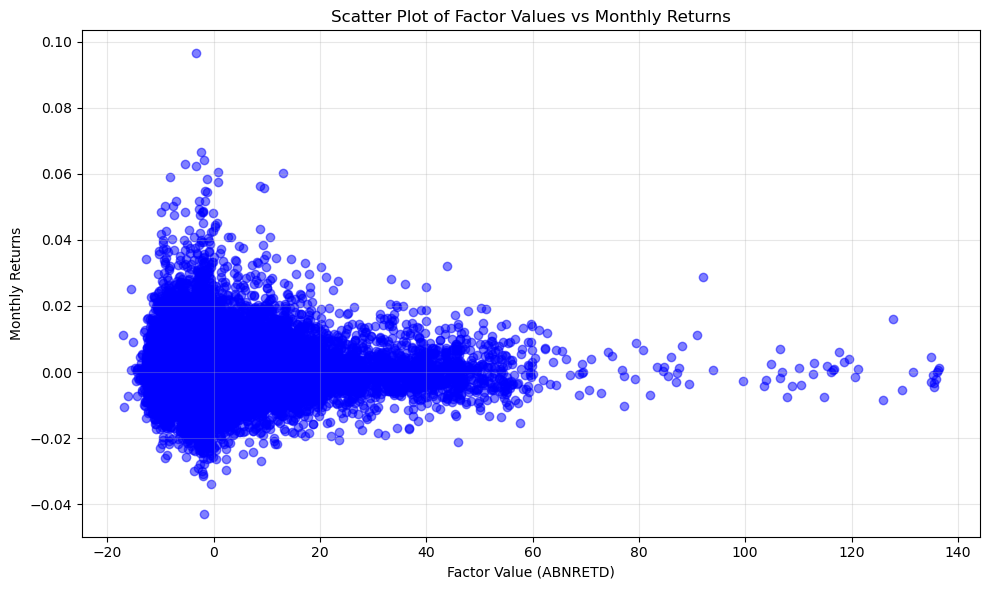

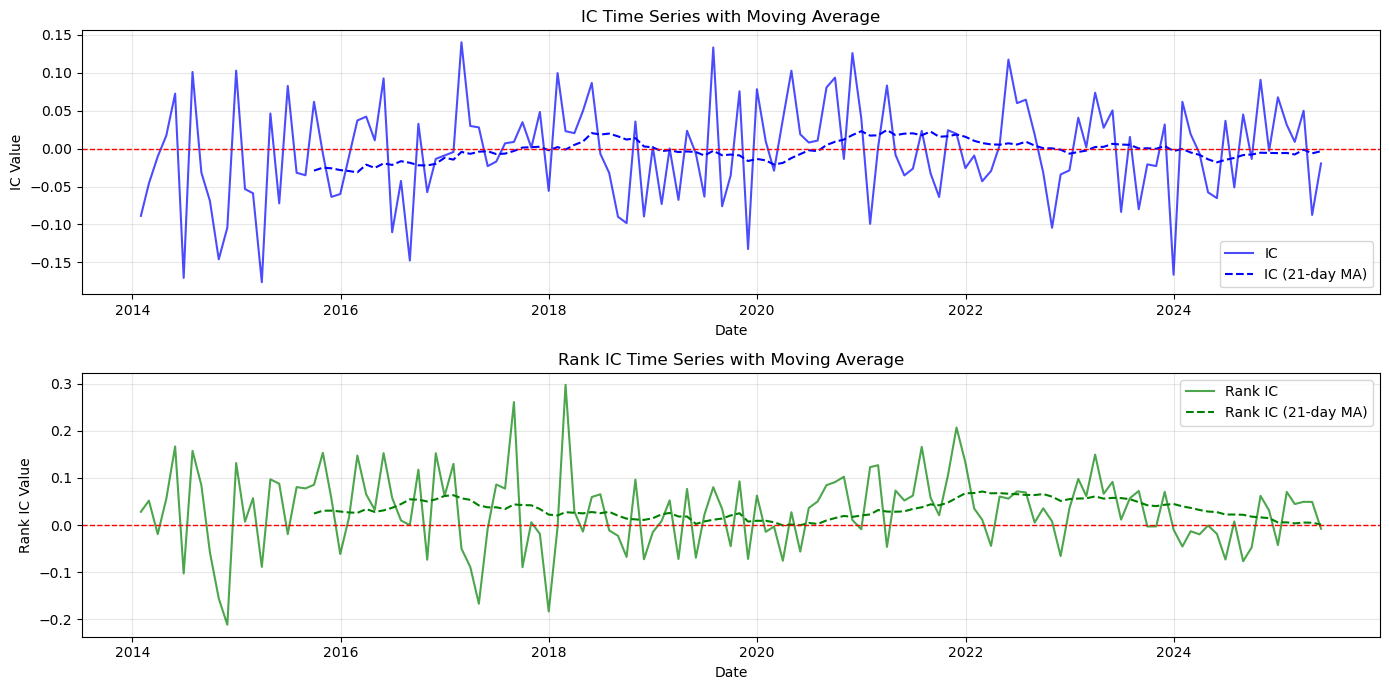

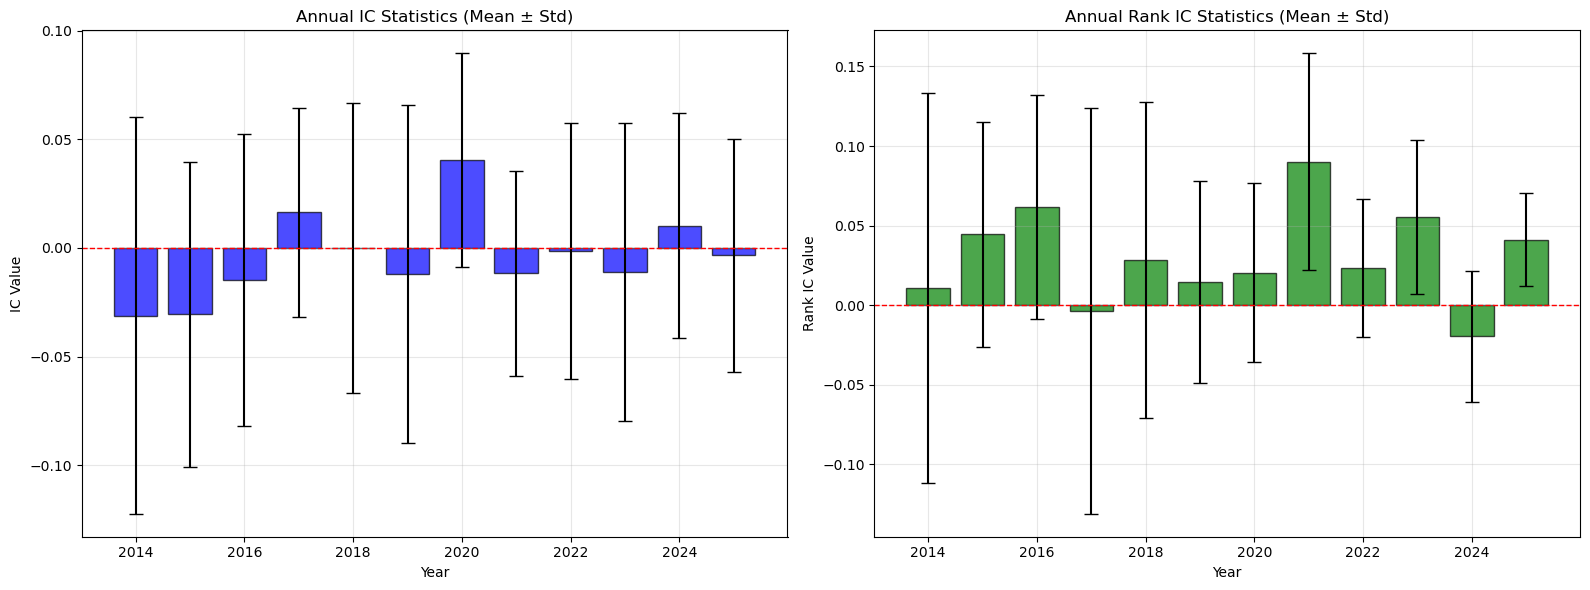

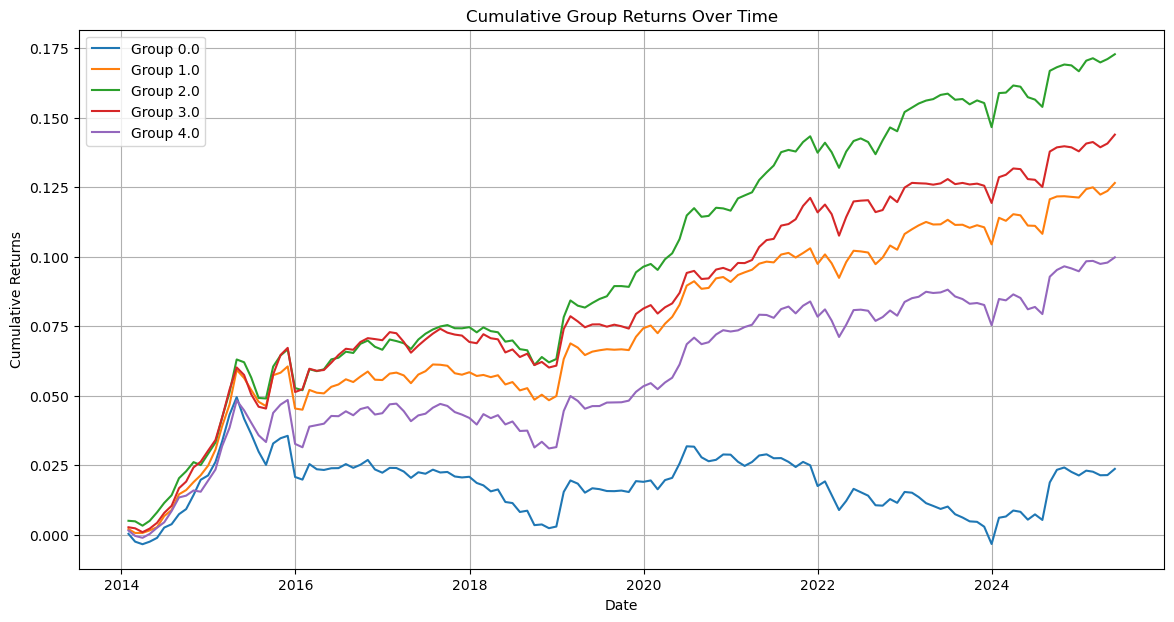

Long position: Group 2.0
Short position: Group 0.0


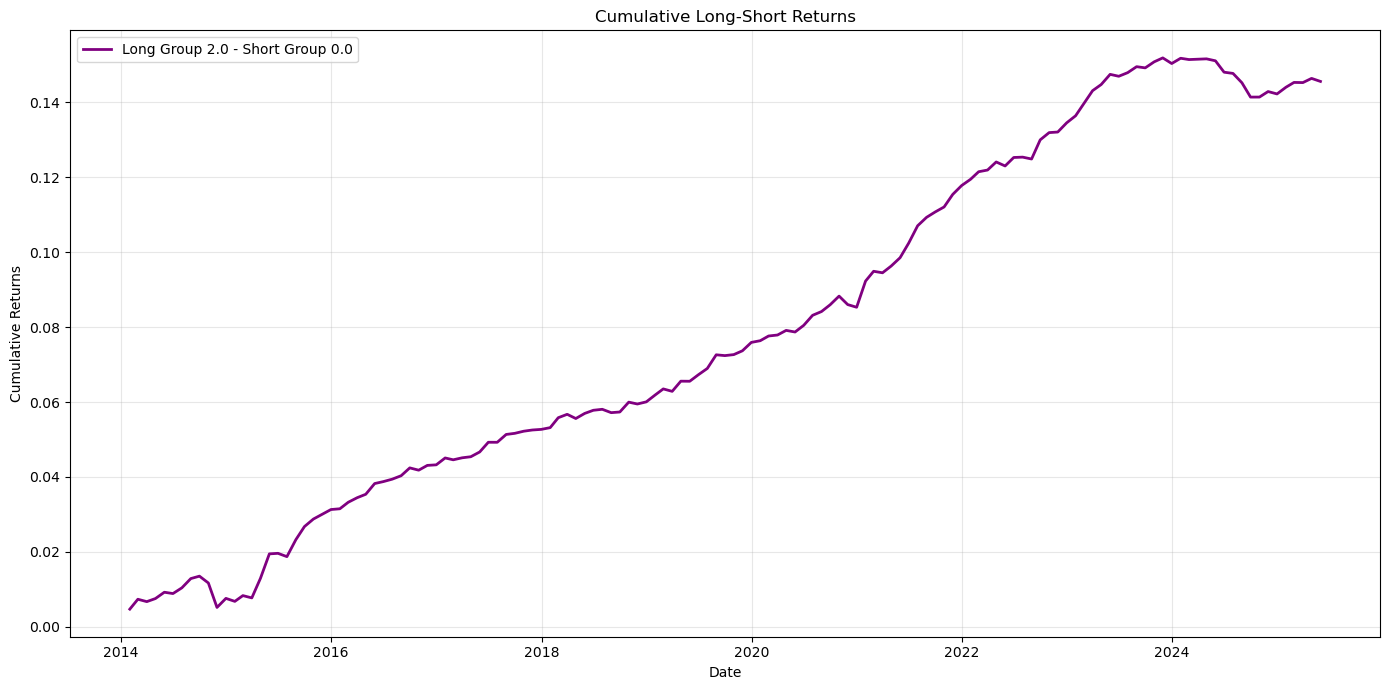

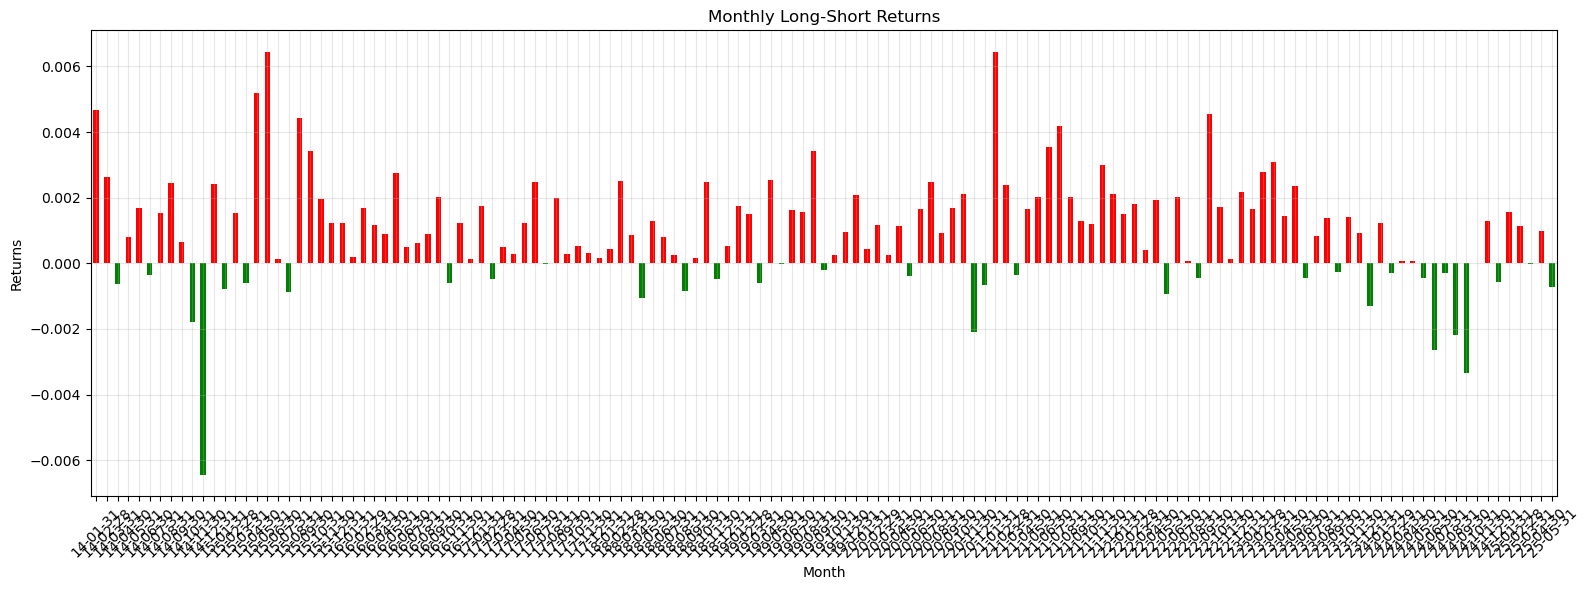

Annual Return: 25.05%
Annual Volatility: 2.71%
Sharpe Ratio: 9.25
Max Drawdown: 1.05%


In [11]:
# ABNRETD因子表现
ic1, rankic1, group_ret1 = simple_factor_test(ABNRETD, ret_close)

plot_factor_performance(ABNRETD, ret_close, ic1, rankic1, group_ret1)

ABNRETAVG因子表现数据


d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  factor1 = factor1.fillna(np.nan)


------------------------------------------------------------
因子统计数据
IC Mean: -0.06%,
 IC Std: 5.89%
Rank IC Mean: 4.52%,
 Rank IC Std: 9.84%
IC t-stat: -0.11
IC > 0 Win Rate: 46.38%
IR: -0.01
------------------------------------------------------------
group_id         0.0       1.0       2.0       3.0       4.0
date                                                        
2014-01-31  0.000375  0.001755  0.002730  0.005398  0.000965
2014-02-28 -0.002361 -0.001662 -0.002150  0.000628 -0.001175
2014-03-31 -0.001040 -0.001157  0.000011 -0.001741 -0.000591
2014-04-30  0.000602  0.001121  0.001410  0.001617  0.001480
2014-05-31  0.001478  0.001240  0.001975  0.002874  0.002342
...              ...       ...       ...       ...       ...
2025-01-31  0.003149  0.003636  0.000752  0.003364  0.002544
2025-02-28  0.001153  0.000008 -0.000259  0.000125  0.000496
2025-03-31 -0.001197 -0.002288 -0.001819 -0.001279 -0.000909
2025-04-30  0.001168  0.001217  0.000232  0.000504  0.000764
2025-05-31  0.0

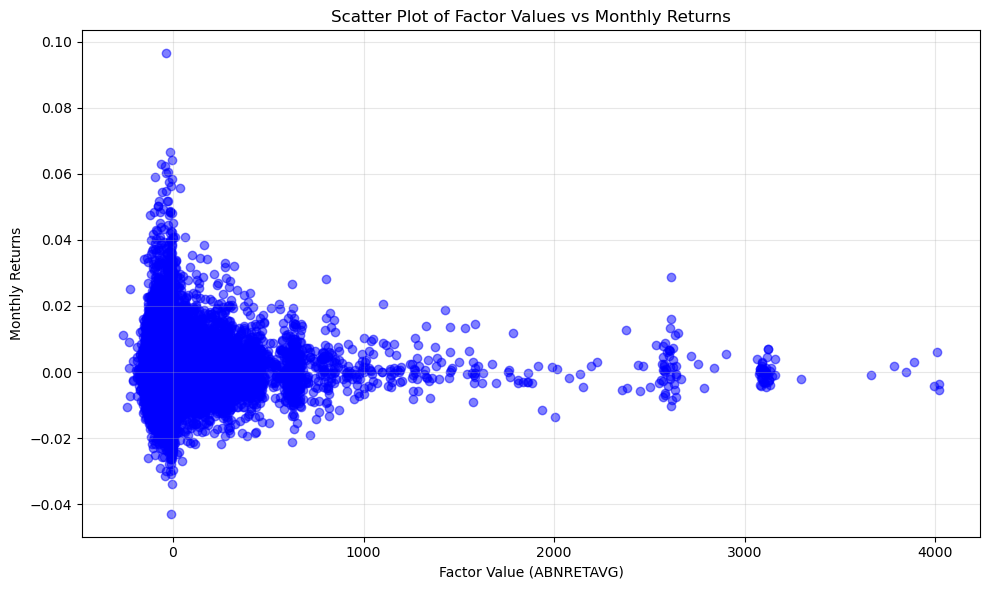

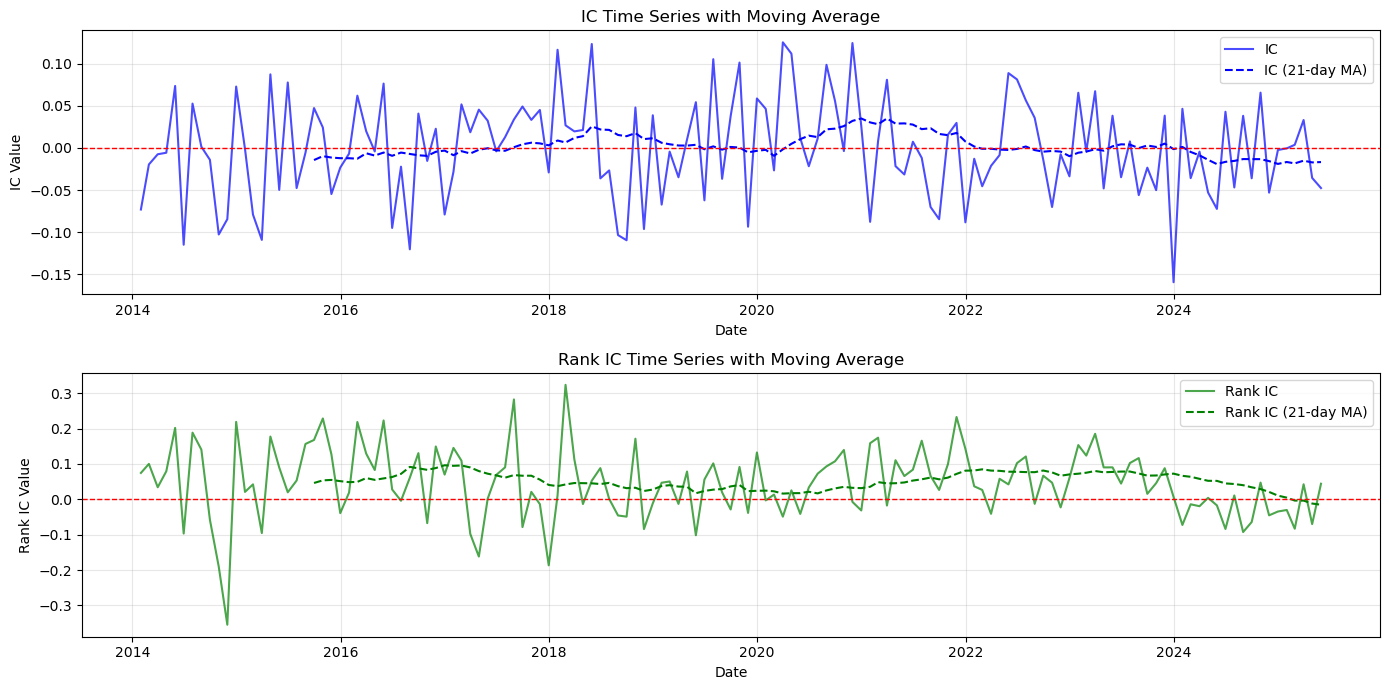

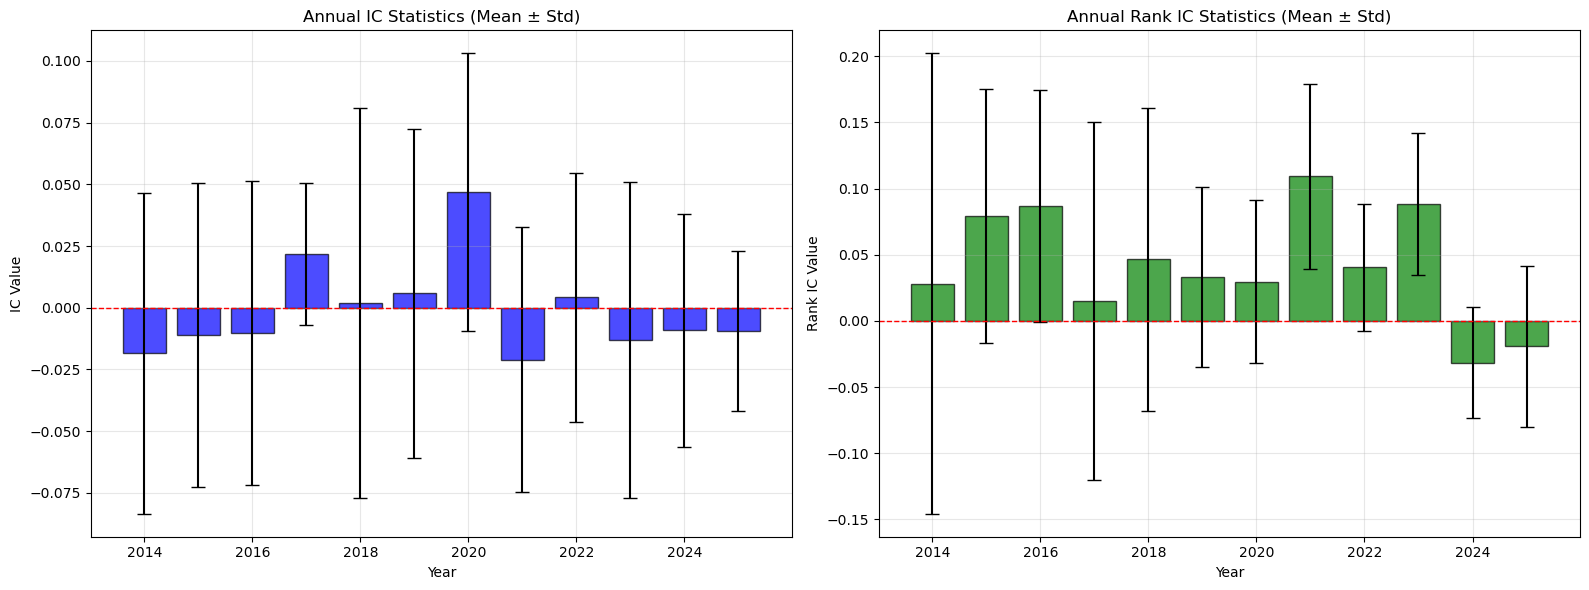

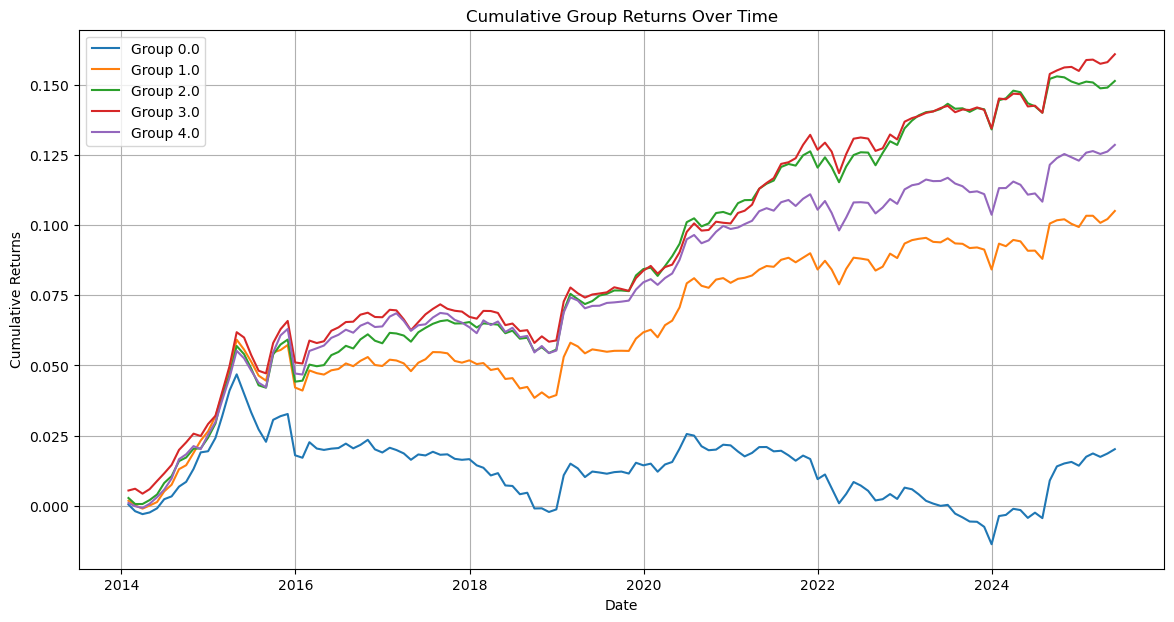

Long position: Group 3.0
Short position: Group 0.0


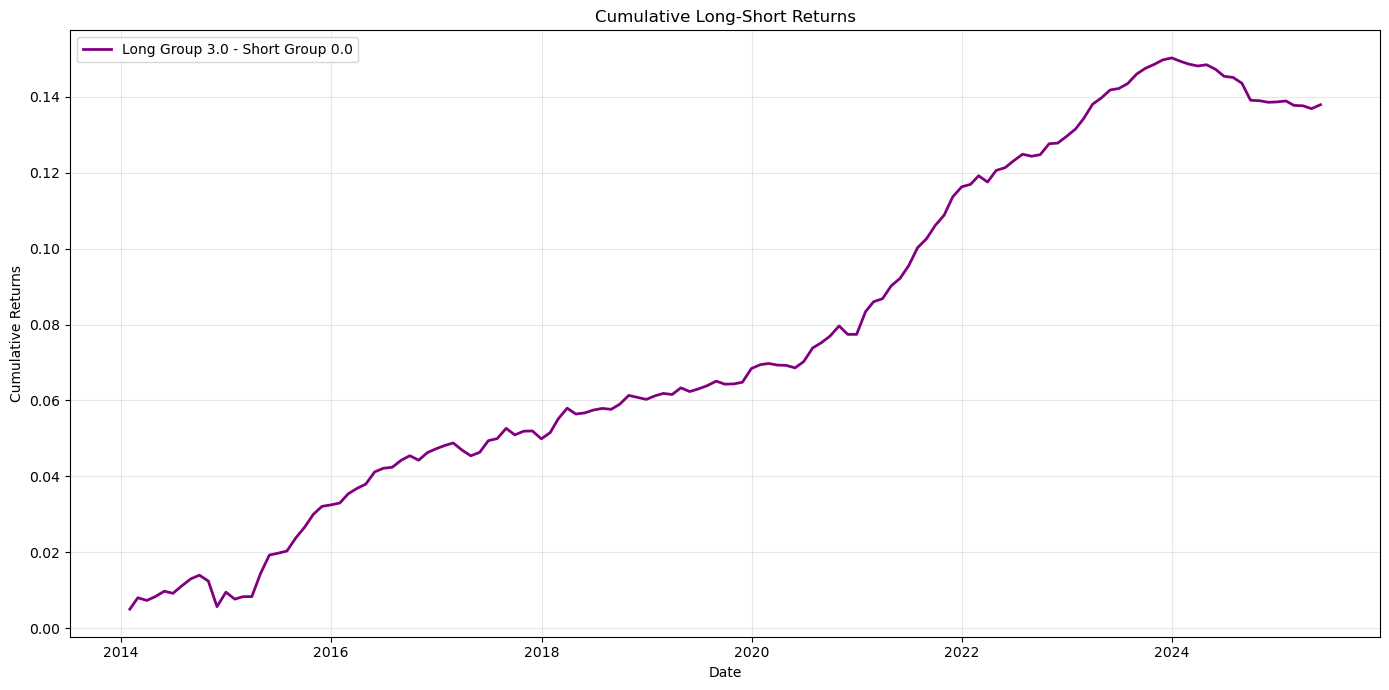

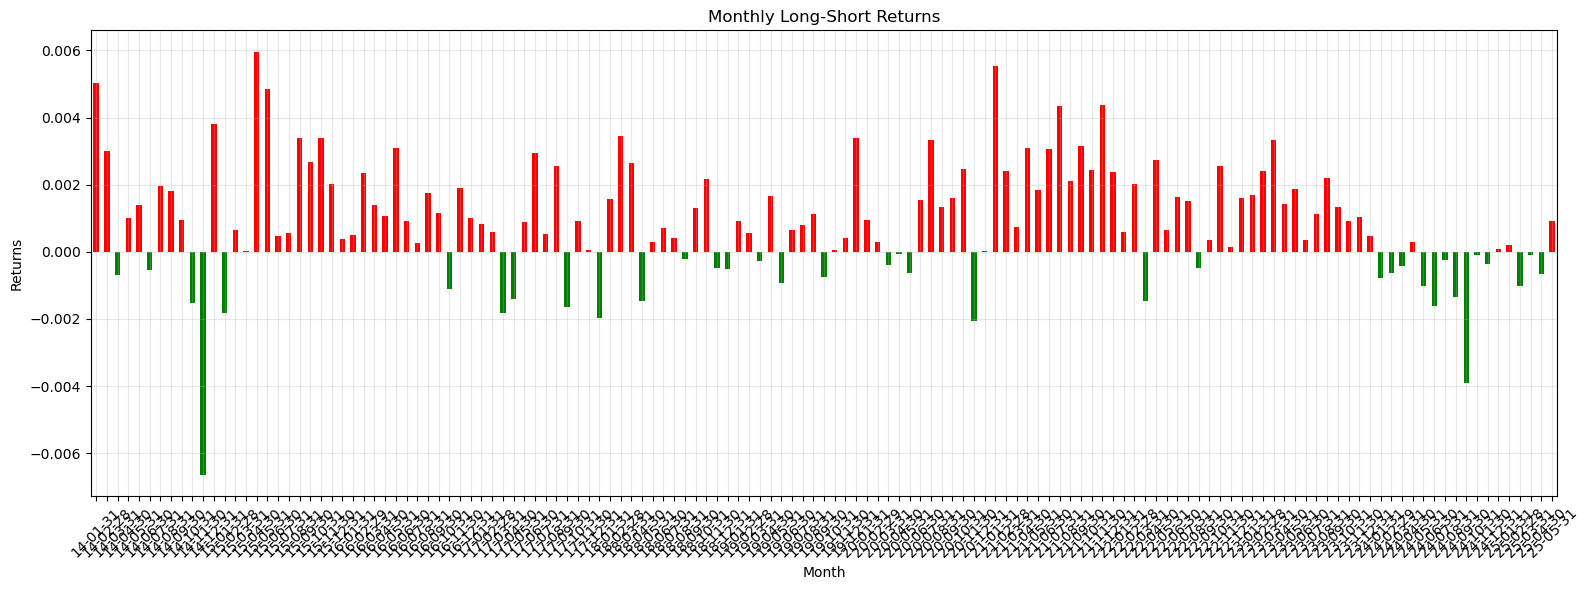

Annual Return: 23.81%
Annual Volatility: 2.84%
Sharpe Ratio: 8.39
Max Drawdown: 1.34%


In [12]:
# ABNRETAVG因子表现数据
print("ABNRETAVG因子表现数据")
ic2, rankic2, group_ret2 = simple_factor_test(ABNRETAVG, ret_close)

plot_factor_performance(ABNRETAVG, ret_close, ic2, rankic2, group_ret2)

ABNVOLD因子表现数据


d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  factor1 = factor1.fillna(np.nan)


------------------------------------------------------------
因子统计数据
IC Mean: -0.65%,
 IC Std: 12.06%
Rank IC Mean: -3.13%,
 Rank IC Std: 11.77%
IC t-stat: -0.63
IC > 0 Win Rate: 47.10%
IR: -0.05
------------------------------------------------------------
group_id         0.0       1.0       2.0       3.0       4.0
date                                                        
2014-01-31  0.001084  0.001909  0.000520  0.002998  0.004721
2014-02-28 -0.001639 -0.000786 -0.002070 -0.000698 -0.002021
2014-03-31 -0.001293 -0.000579 -0.000303 -0.000724 -0.001620
2014-04-30  0.001588  0.001643  0.001400  0.001094  0.000505
2014-05-31  0.001854  0.002248  0.001828  0.003022  0.000957
...              ...       ...       ...       ...       ...
2025-01-31  0.002731  0.002078  0.001747  0.002448  0.004440
2025-02-28  0.001008  0.000775  0.000580 -0.000161 -0.000677
2025-03-31 -0.001468 -0.001106 -0.001161 -0.002242 -0.001514
2025-04-30  0.000105  0.000687  0.000632  0.001497  0.000962
2025-05-31  

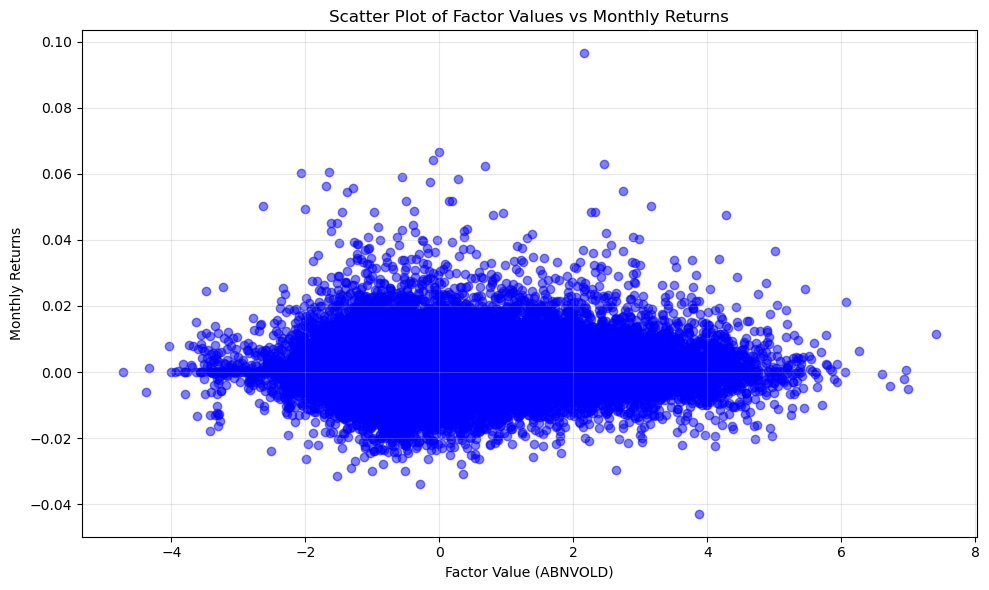

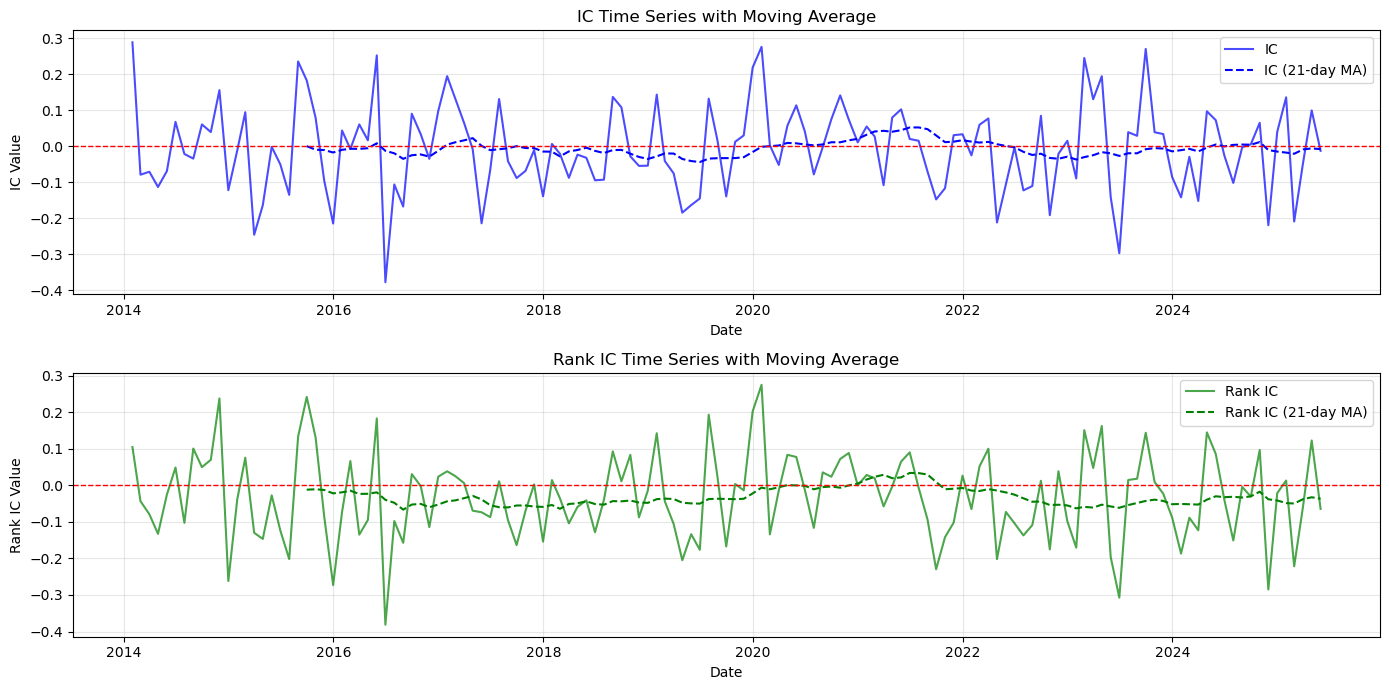

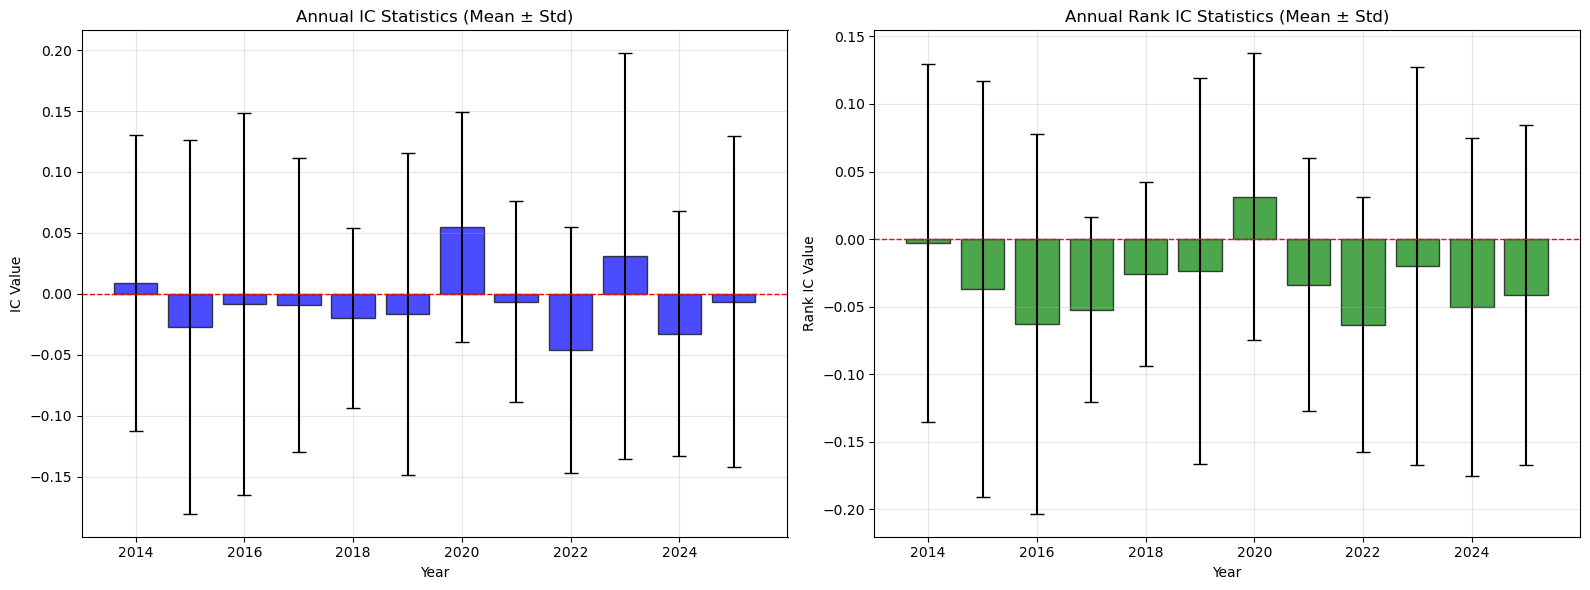

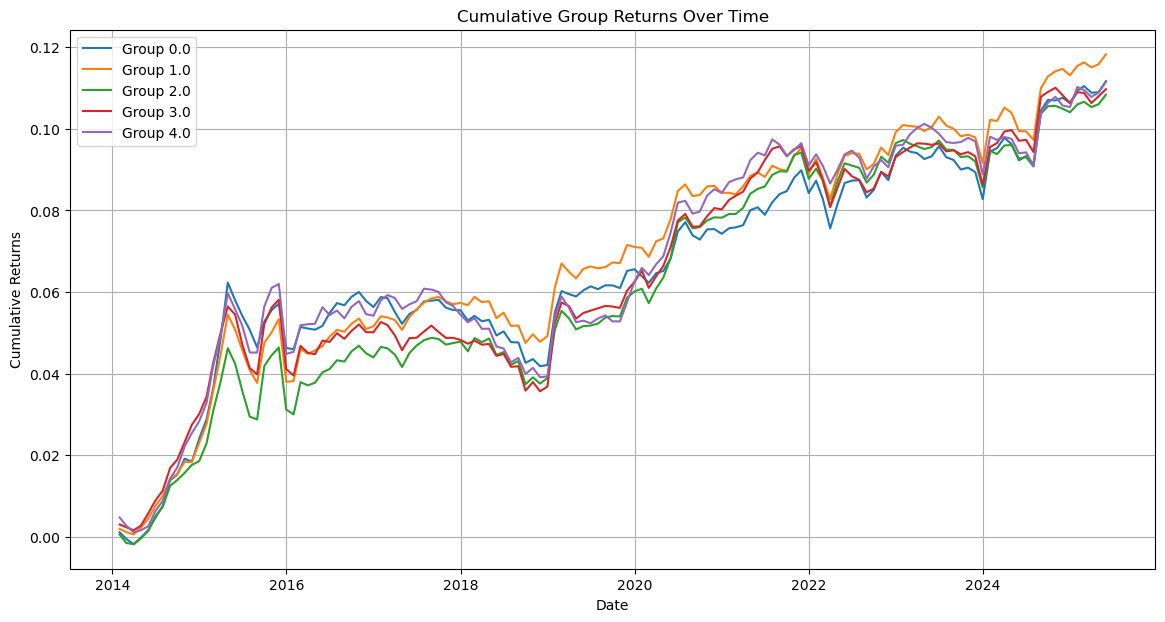

Long position: Group 1.0
Short position: Group 2.0


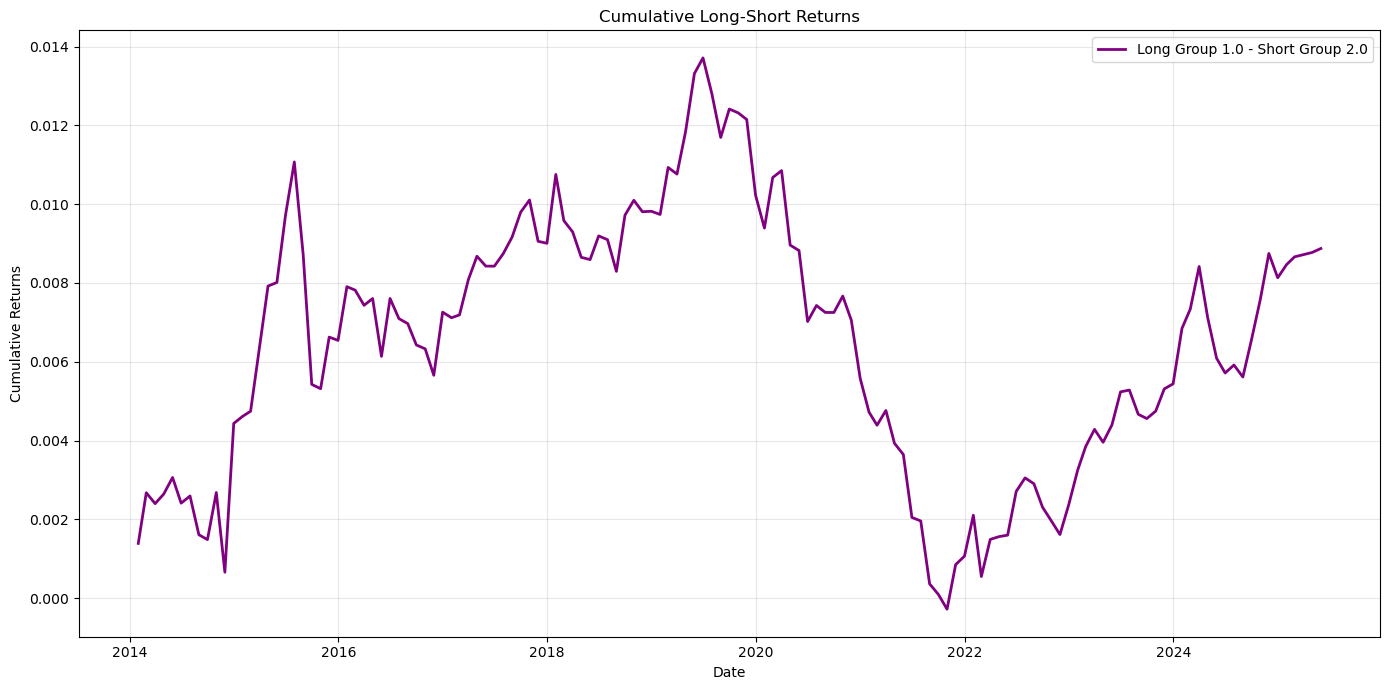

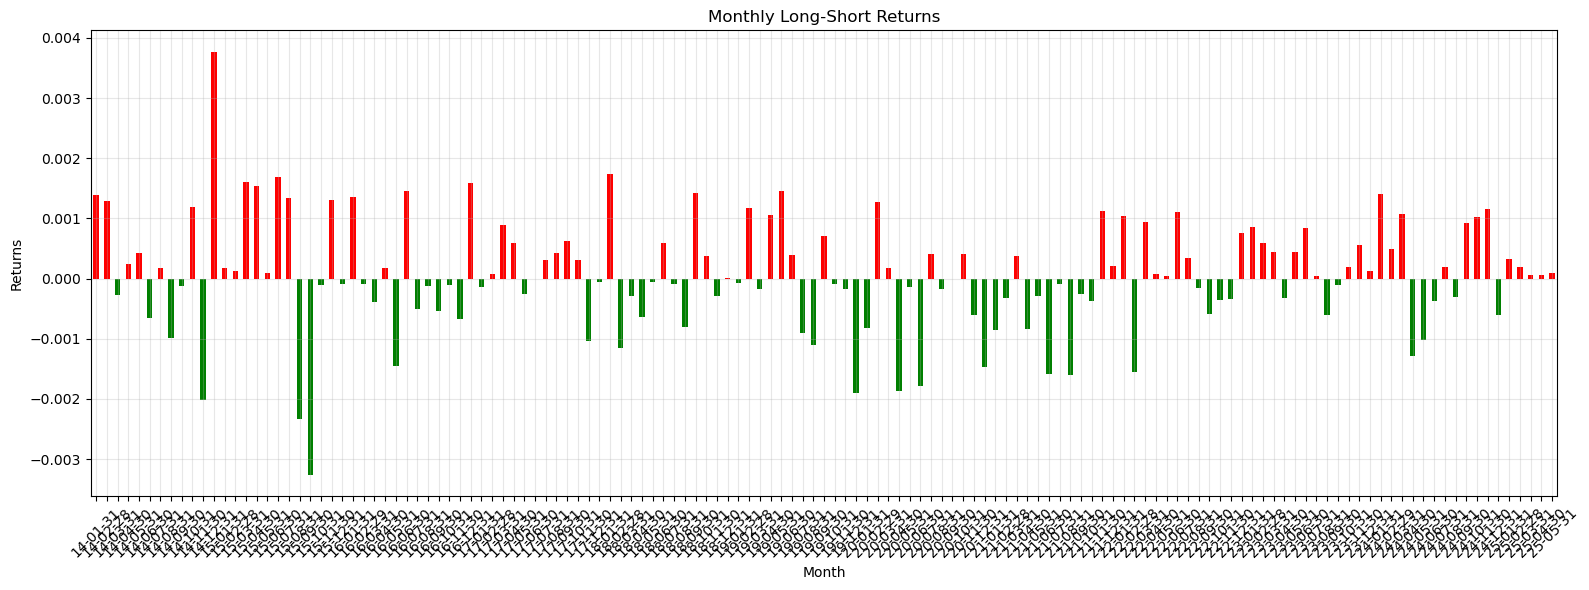

Annual Return: 1.64%
Annual Volatility: 1.52%
Sharpe Ratio: 1.08
Max Drawdown: 1.40%


In [13]:
# ABNVOLD因子表现数据
print("ABNVOLD因子表现数据")
ic3, rankic3, group_ret3 = simple_factor_test(ABNVOLD, ret_close)

plot_factor_performance(ABNVOLD, ret_close, ic3, rankic3, group_ret3)

ABNVOLAVG因子表现数据


d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  factor1 = factor1.fillna(np.nan)


------------------------------------------------------------
因子统计数据
IC Mean: 0.08%,
 IC Std: 13.54%
Rank IC Mean: -2.06%,
 Rank IC Std: 13.04%
IC t-stat: 0.07
IC > 0 Win Rate: 48.55%
IR: 0.01
------------------------------------------------------------
group_id         0.0       1.0       2.0       3.0       4.0
date                                                        
2014-01-31  0.002350  0.001059  0.001035  0.002285  0.004511
2014-02-28 -0.002073 -0.001055 -0.001290 -0.000622 -0.002161
2014-03-31 -0.000658 -0.000613 -0.000413 -0.001212 -0.001623
2014-04-30  0.001555  0.001511  0.001185  0.001359  0.000620
2014-05-31  0.001458  0.002057  0.002431  0.002468  0.001495
...              ...       ...       ...       ...       ...
2025-01-31  0.001988  0.002544  0.001512  0.002730  0.004670
2025-02-28  0.001107  0.000847 -0.000042  0.000587 -0.000975
2025-03-31 -0.001470 -0.001394 -0.000817 -0.001742 -0.002068
2025-04-30  0.000223  0.000922  0.000718  0.000334  0.001686
2025-05-31  0.0

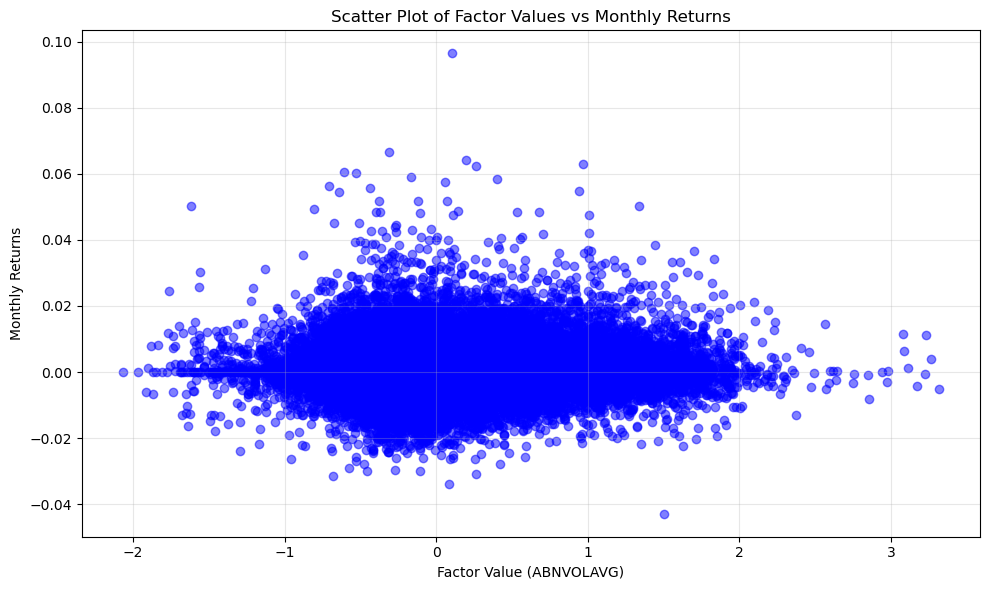

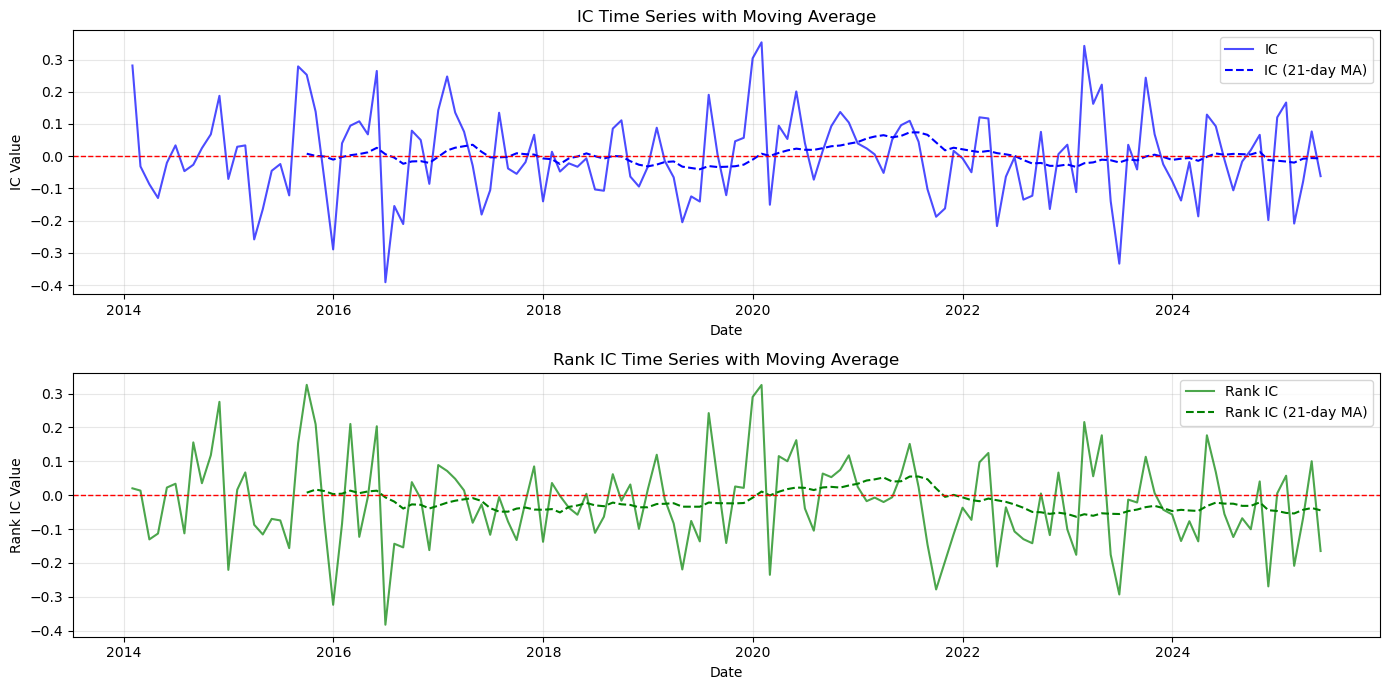

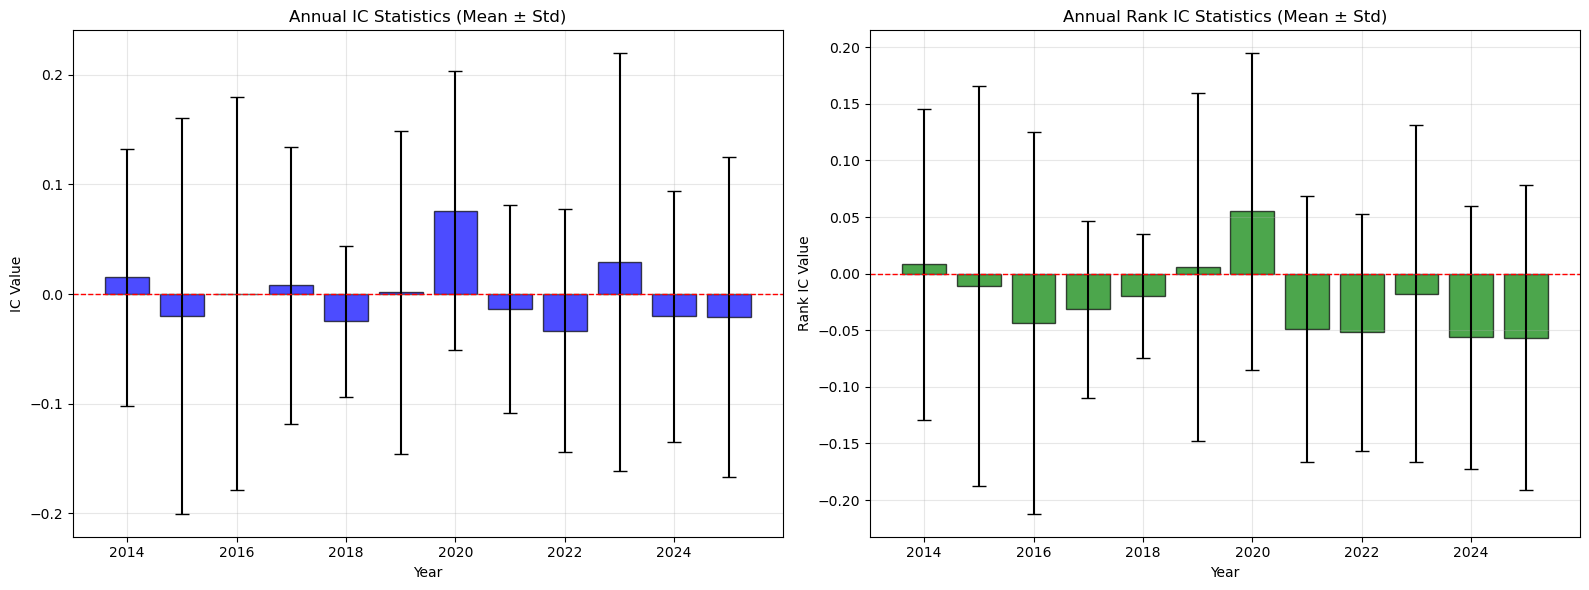

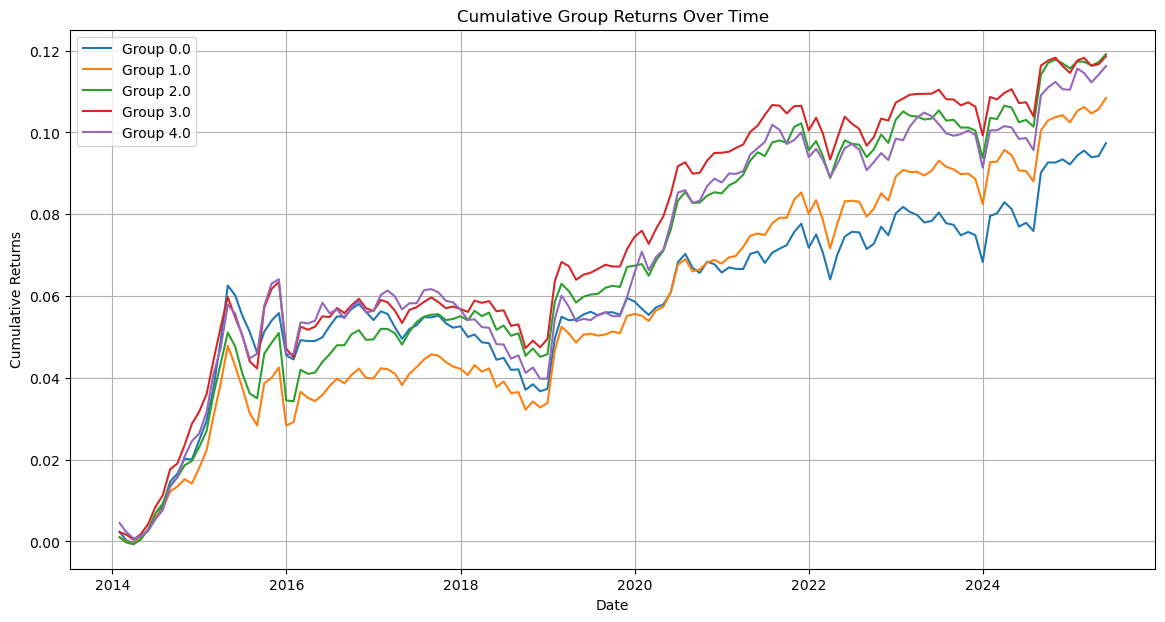

Long position: Group 2.0
Short position: Group 0.0


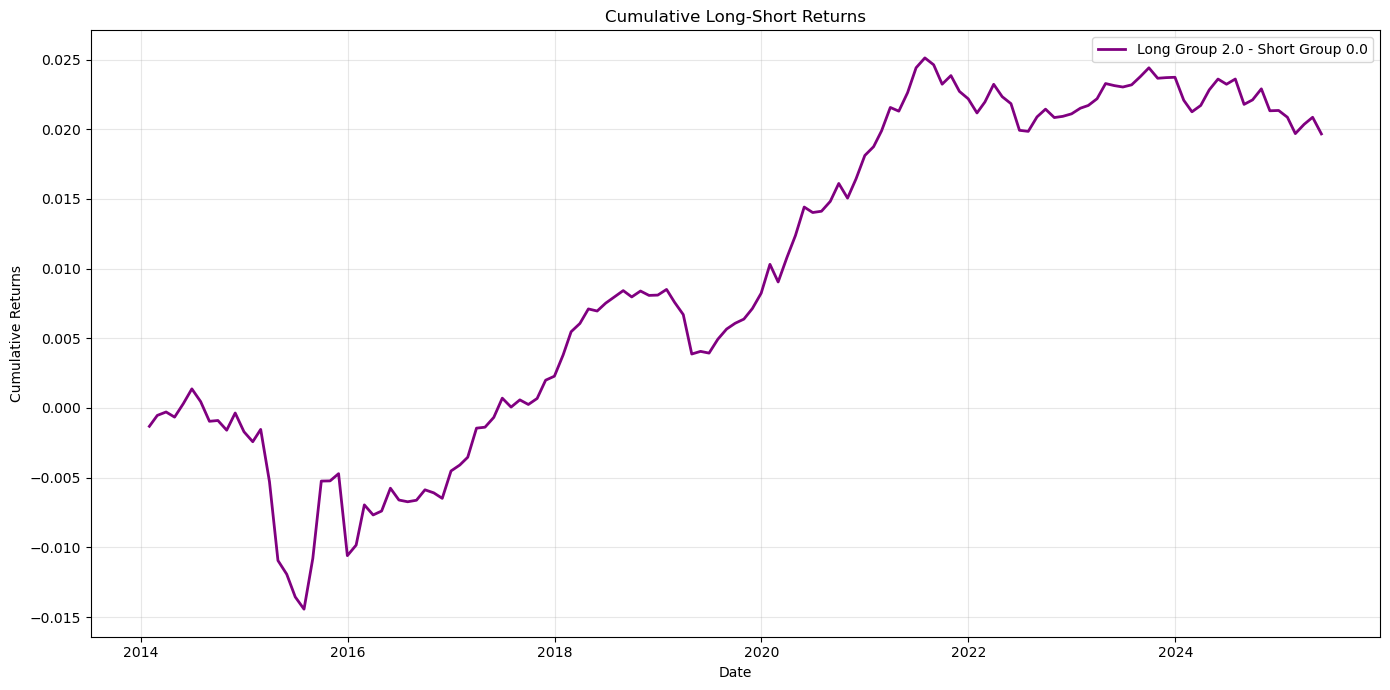

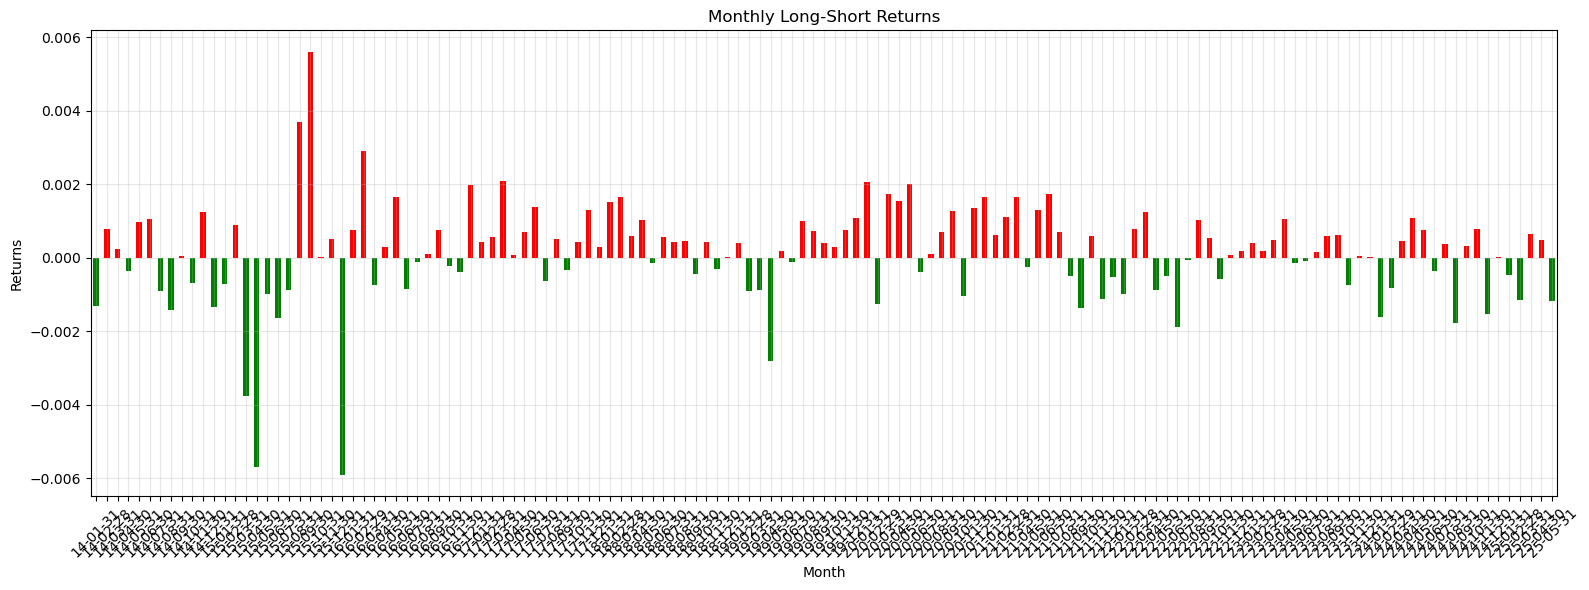

Annual Return: 3.61%
Annual Volatility: 2.17%
Sharpe Ratio: 1.66
Max Drawdown: 1.58%


In [14]:
# ABNVOLAVG因子表现数据
print("ABNVOLAVG因子表现数据")
ic4, rankic4, group_ret4 = simple_factor_test(ABNVOLAVG, ret_close)

plot_factor_performance(ABNVOLAVG, ret_close, ic4, rankic4, group_ret4)

ATTN因子表现数据


d:\Sherlock\Internship\SMS intern\Factor_BackTest\BackTest_Toolkit.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  factor1 = factor1.fillna(np.nan)


------------------------------------------------------------
因子统计数据
IC Mean: -1.79%,
 IC Std: 11.71%
Rank IC Mean: -1.24%,
 Rank IC Std: 14.96%
IC t-stat: -1.79
IC > 0 Win Rate: 39.86%
IR: -0.15
------------------------------------------------------------
group_id         0.0       1.0       2.0       3.0       4.0
date                                                        
2014-01-31  0.000021  0.002194  0.002913  0.003087  0.003009
2014-02-28 -0.002533 -0.001424 -0.000348  0.000052 -0.002468
2014-03-31 -0.000156 -0.000596 -0.001532 -0.000653 -0.001581
2014-04-30  0.000832  0.001882  0.001616  0.001082  0.000817
2014-05-31  0.002025  0.002148  0.002348  0.001606  0.001783
...              ...       ...       ...       ...       ...
2025-01-31  0.002413  0.003087  0.000557  0.003085  0.004301
2025-02-28 -0.000187  0.000824  0.001268  0.000193 -0.000575
2025-03-31 -0.001043 -0.001859 -0.001420 -0.001535 -0.001635
2025-04-30  0.000091  0.001280  0.001216  0.001054  0.000242
2025-05-31  

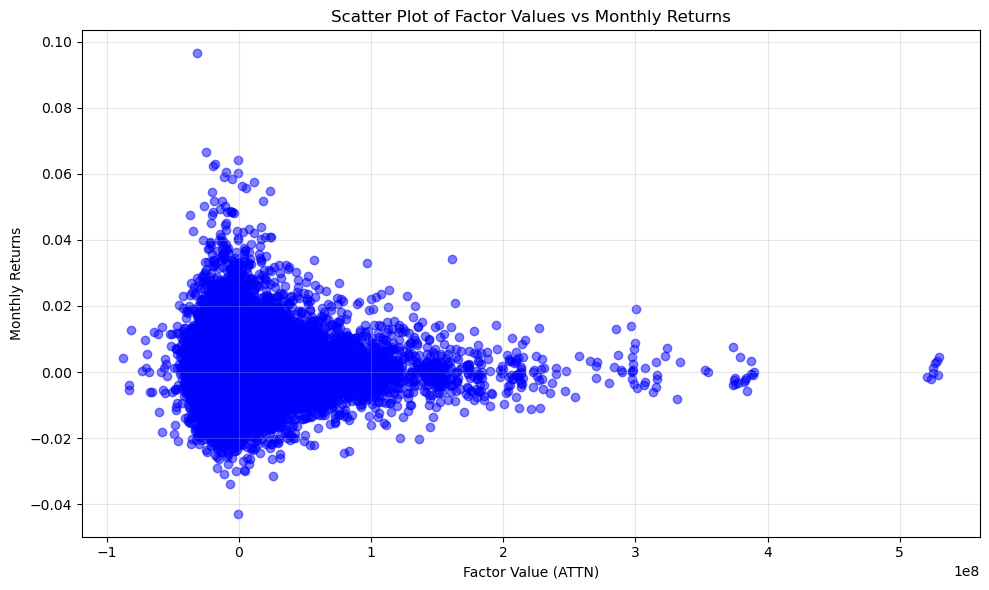

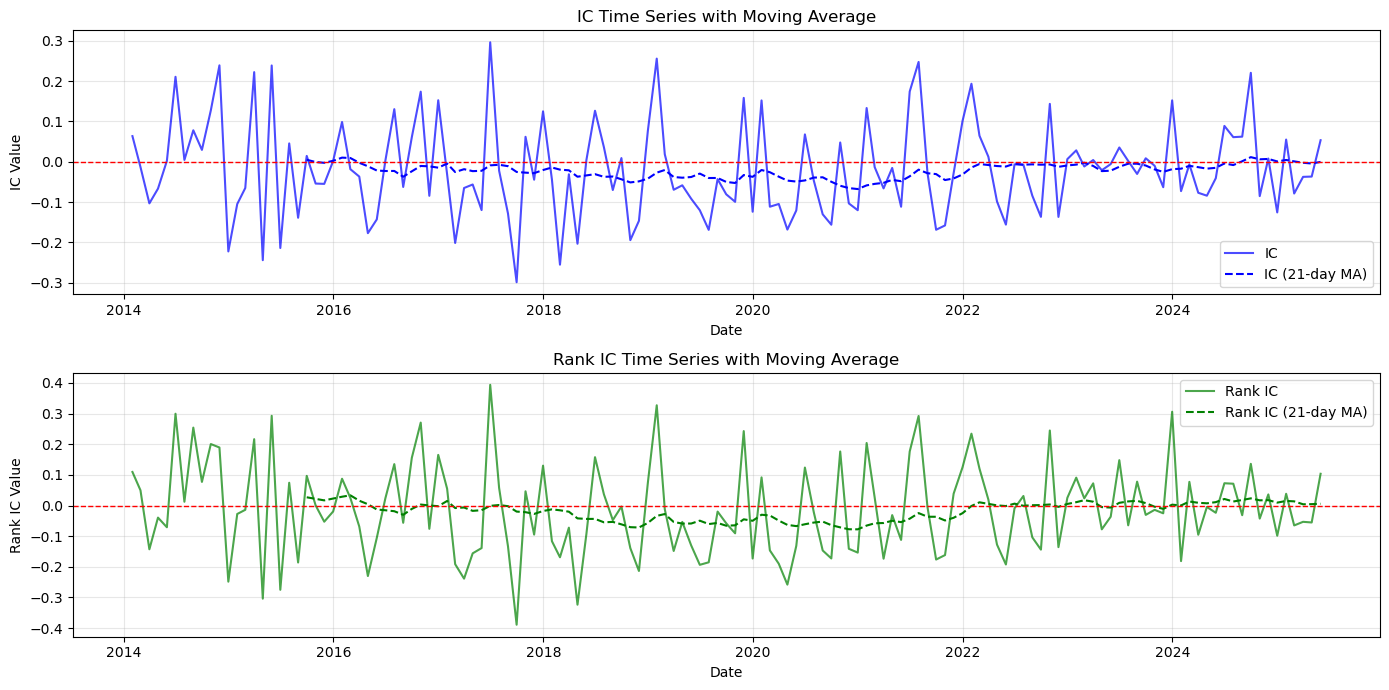

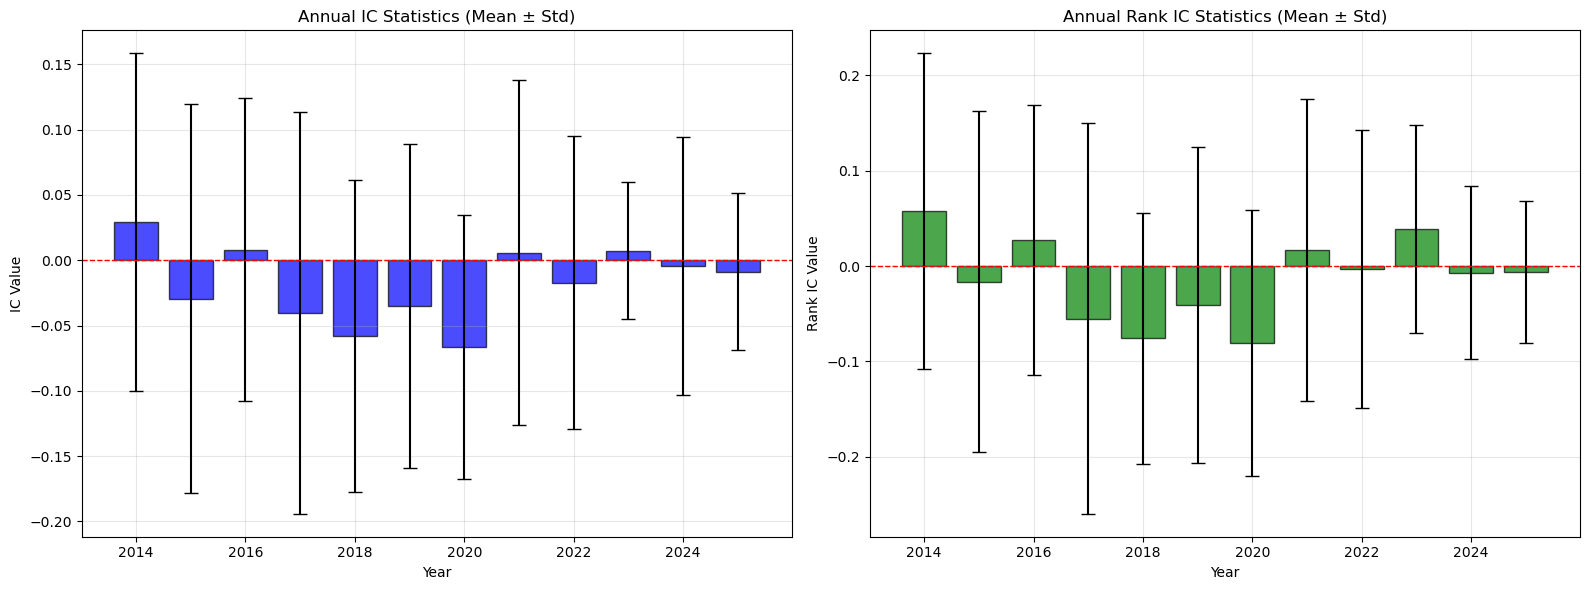

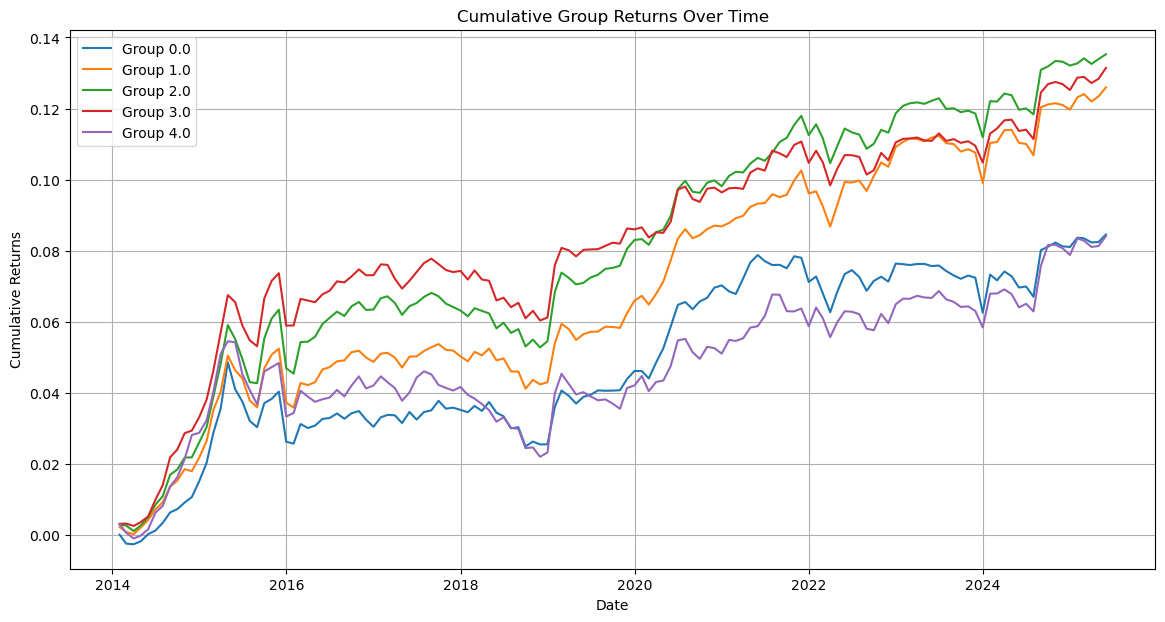

Long position: Group 2.0
Short position: Group 4.0


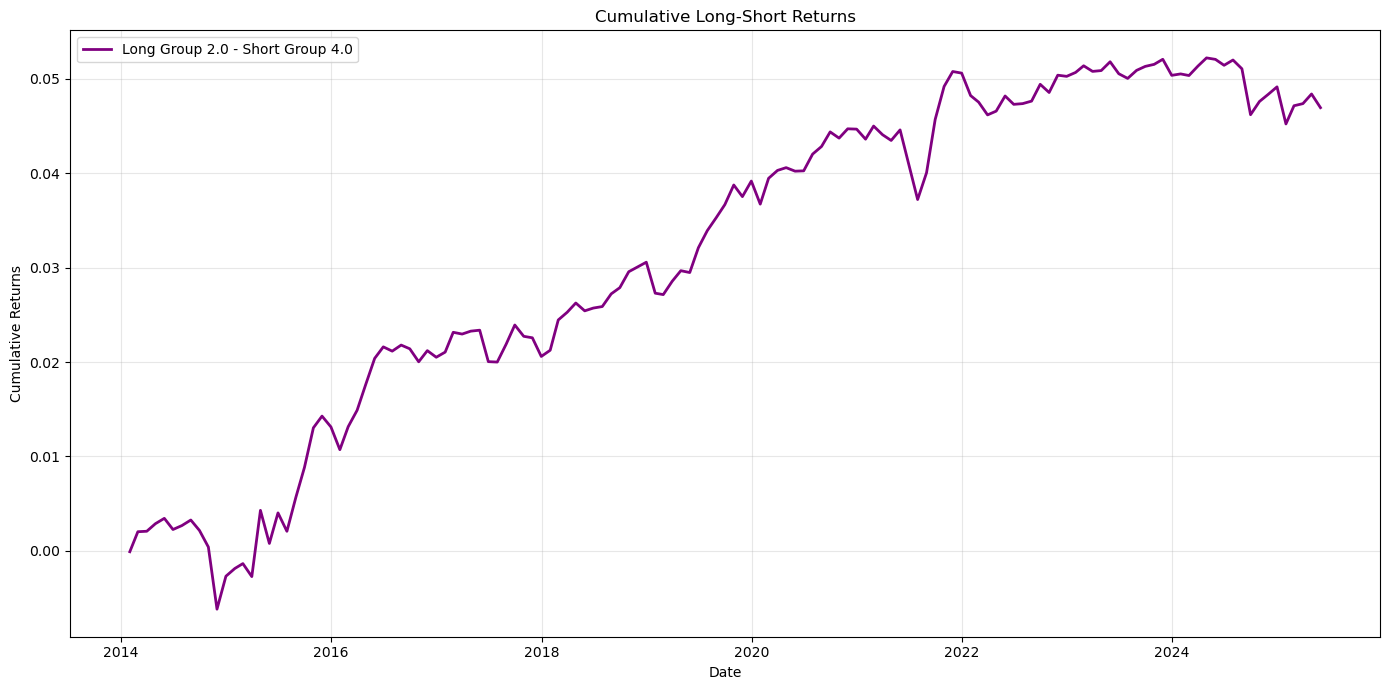

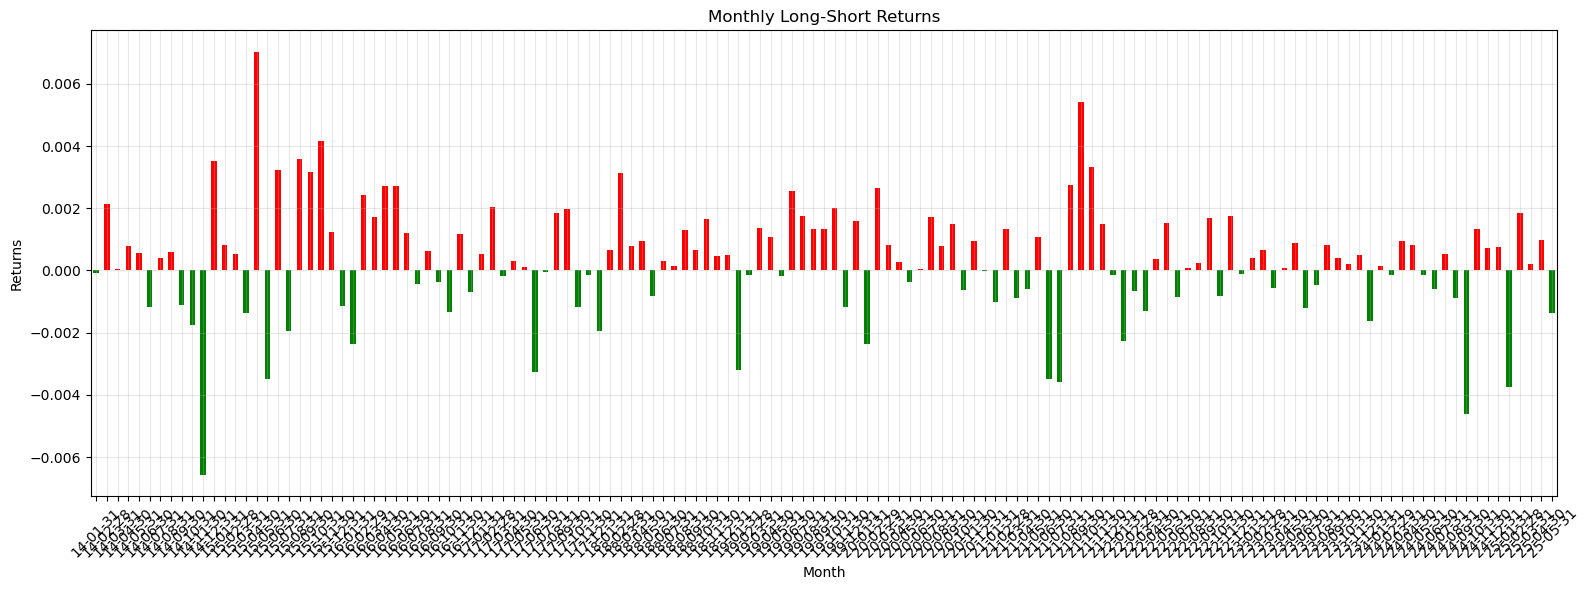

Annual Return: 8.48%
Annual Volatility: 2.92%
Sharpe Ratio: 2.90
Max Drawdown: 0.96%


In [15]:
# ATTN因子表现数据
print("ATTN因子表现数据")
ic5, rankic5, group_ret5 = simple_factor_test(ATTN, ret_close)  

plot_factor_performance(ATTN, ret_close, ic5, rankic5, group_ret5)